In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [8]:
pd.set_option('display.max_columns', None)


In [9]:
df = pd.read_csv('data/probabilities.csv')


In [10]:
df.columns.tolist() 

['year',
 'gisjoin',
 'state',
 'county',
 'P(C)',
 'P(households_income_under_10k|C)',
 'P(households_income_10k_15k|C)',
 'P(households_income_15k_25k|C)',
 'P(households_income_25k_plus|C)',
 'P(persons_male|C)',
 'P(persons_female|C)',
 'P(male_never_married|C)',
 'P(male_married|C)',
 'P(male_separated|C)',
 'P(male_widowed|C)',
 'P(male_divorced|C)',
 'P(female_never_married|C)',
 'P(female_married|C)',
 'P(female_separated|C)',
 'P(female_widowed|C)',
 'P(female_divorced|C)',
 'P(male_18_24_less_than_9th|C)',
 'P(male_18_24_some_hs|C)',
 'P(male_18_24_hs_grad|C)',
 'P(male_18_24_some_college|C)',
 'P(male_18_24_associates|C)',
 'P(male_18_24_bachelors|C)',
 'P(male_18_24_graduate|C)',
 'P(male_25_34_less_than_9th|C)',
 'P(male_25_34_some_hs|C)',
 'P(male_25_34_hs_grad|C)',
 'P(male_25_34_some_college|C)',
 'P(male_25_34_associates|C)',
 'P(male_25_34_bachelors|C)',
 'P(male_25_34_graduate|C)',
 'P(male_35_44_less_than_9th|C)',
 'P(male_35_44_some_hs|C)',
 'P(male_35_44_hs_grad|C

In [11]:
df.shape

(12360, 119)

In [13]:
# Define the columns involved in determining the winner
competitor_columns = ['P(democrat|C)',
 'P(other|C)',
 'P(republican|C)',]

# Check if competitor columns exist
if not all(col in df.columns for col in competitor_columns):
    raise ValueError(f"One or more competitor columns {competitor_columns} not found in DataFrame.")


In [14]:
df[competitor_columns]

,P(democrat|C),P(other|C),P(republican|C)
0,0.114627,0.002728,0.327401
1,0.110279,0.004301,0.348545
2,0.205675,0.002419,0.211777
3,0.101681,0.003671,0.276957
4,0.062125,0.006280,0.359645
...,...,...,...
12355,0.090853,0.015352,0.290620
12356,0.421828,0.025615,0.185942
12357,0.077436,0.018106,0.364840
12358,0.084272,0.017605,0.420065


In [15]:

# Determine the winning category based on max value
df['winning_category'] = df[competitor_columns].idxmax(axis=1)

# Create the binary target: 1 if Democrat wins, 0 otherwise
df['target_democrat_win'] = (df['P(democrat|C)'] > df['P(republican|C)']).astype(int)

y = df['target_democrat_win']
class_names = ['Democrat Lose', 'Democrat Win'] # For plotting/reporting
num_classes = 2 # Binary classification


In [16]:
df

,year,gisjoin,state,county,P(C),P(households_income_under_10k|C),P(households_income_10k_15k|C),P(households_income_15k_25k|C),P(households_income_25k_plus|C),P(persons_male|C),P(persons_female|C),P(male_never_married|C),P(male_married|C),P(male_separated|C),P(male_widowed|C),P(male_divorced|C),P(female_never_married|C),P(female_married|C),P(female_separated|C),P(female_widowed|C),P(female_divorced|C),P(male_18_24_less_than_9th|C),P(male_18_24_some_hs|C),P(male_18_24_hs_grad|C),P(male_18_24_some_college|C),P(male_18_24_associates|C),P(male_18_24_bachelors|C),P(male_18_24_graduate|C),P(male_25_34_less_than_9th|C),P(male_25_34_some_hs|C),P(male_25_34_hs_grad|C),P(male_25_34_some_college|C),P(male_25_34_associates|C),P(male_25_34_bachelors|C),P(male_25_34_graduate|C),P(male_35_44_less_than_9th|C),P(male_35_44_some_hs|C),P(male_35_44_hs_grad|C),P(male_35_44_some_college|C),P(male_35_44_associates|C),P(male_35_44_bachelors|C),P(male_35_44_graduate|C),P(male_45_64_less_than_9th|C),P(male_45_64_some_hs|C),P(male_45_64_hs_grad|C),P(male_45_64_some_college|C),P(male_45_64_associates|C),P(male_45_64_bachelors|C),P(male_45_64_graduate|C),P(male_65plus_less_than_9th|C),P(male_65plus_some_hs|C),P(male_65plus_hs_grad|C),P(male_65plus_some_college|C),P(male_65plus_associates|C),P(male_65plus_bachelors|C),P(male_65plus_graduate|C),P(female_18_24_less_than_9th|C),P(female_18_24_some_hs|C),P(female_18_24_hs_grad|C),P(female_18_24_some_college|C),P(female_18_24_associates|C),P(female_18_24_bachelors|C),P(female_18_24_graduate|C),P(female_25_34_less_than_9th|C),P(female_25_34_some_hs|C),P(female_25_34_hs_grad|C),P(female_25_34_some_college|C),P(female_25_34_associates|C),P(female_25_34_bachelors|C),P(female_25_34_graduate|C),P(female_35_44_less_than_9th|C),P(female_35_44_some_hs|C),P(female_35_44_hs_grad|C),P(female_35_44_some_college|C),P(female_35_44_associates|C),P(female_35_44_bachelors|C),P(female_35_44_graduate|C),P(female_45_64_less_than_9th|C),P(female_45_64_some_hs|C),P(female_45_64_hs_grad|C),P(female_45_64_some_college|C),P(female_45_64_associates|C),P(female_45_64_bachelors|C),P(female_45_64_graduate|C),P(female_65plus_less_than_9th|C),P(female_65plus_some_hs|C),P(female_65plus_hs_grad|C),P(female_65plus_some_college|C),P(female_65plus_associates|C),P(female_65plus_bachelors|C),P(female_65plus_graduate|C),P(male_white|C),P(female_white|C),P(male_black|C),P(female_black|C),P(male_aian|C),P(female_aian|C),P(male_asian|C),P(female_asian|C),P(male_nhpi|C),P(female_nhpi|C),P(male_other|C),P(female_other|C),P(male_multi|C),P(female_multi|C),P(persons_native|C),P(persons_foreign_born|C),P(labor_force_total|C),P(labor_force_armed|C),P(labor_force_civilian|C),P(labor_force_employed|C),P(labor_force_unemployed|C),P(not_in_labor_force|C),P(persons_hispanic|C),P(persons_below_poverty|C),P(democrat|C),P(other|C),P(republican|C),P(non_voter|C),winning_category,target_democrat_win
0,2008,G0100010,Alabama,Autauga County,0.000177,0.066741,0.050512,0.087433,0.795314,0.484997,0.515003,0.104468,0.222256,0.009538,0.008184,0.037588,0.094723,0.220243,0.010121,0.039413,0.051190,0.000602,0.011532,0.015991,0.012435,0.000470,0.001373,0.000000,0.001674,0.006227,0.022199,0.014392,0.001881,0.008071,0.003198,0.003292,0.005192,0.025473,0.018568,0.002671,0.012793,0.006791,0.005493,0.011815,0.038228,0.025040,0.009482,0.021371,0.009764,0.004910,0.005079,0.017948,0.010159,0.001185,0.003932,0.005061,0.000621,0.007205,0.012247,0.017233,0.001674,0.003462,0.000677,0.002220,0.004910,0.020374,0.012812,0.006396,0.012153,0.003330,0.003292,0.005079,0.026075,0.021108,0.007600,0.013301,0.004327,0.003311,0.012116,0.044963,0.026997,0.010742,0.018662,0.010065,0.007168,0.011720,0.029292,0.010573,0.001166,0.003255,0.002559,0.387264,0.403462,0.085034,0.093839,0.001091,0.002069,0.002502,0.004045,0.000000,0.000000,0.003330,0.002765,0.005776,0.008823,0.980152,0.019848,0.501082,0.012849,0.469739,0.457925,0.030308,0.257643,0.023196,0.105785,0.114627,0.002728,0.327401,0.555244,P(republican|C)

In [18]:
print(f"\nTarget variable created: 'target_democrat_win' (Binary)")
print(f"Classes: {class_names}")
print(f"Value counts (0 = Democrat Lose, 1 = Democrat Win):\n{y.value_counts()}")
print(f"Win percentage for Democrat: {y.mean() * 100:.2f}%")



Target variable created: 'target_democrat_win' (Binary)
Classes: ['Democrat Lose', 'Democrat Win']
Value counts (0 = Democrat Lose, 1 = Democrat Win):
target_democrat_win
0    9804
1    2556
Name: count, dtype: int64
Win percentage for Democrat: 20.68%


In [20]:
# Define features (X) - Exclude identifiers and ALL competitor cols, plus the derived target/winner cols
identifier_cols = ['gisjoin', 'state', 'county']
# Keep 'year' for now, assuming it might be a useful feature
feature_cols = [col for col in df.columns if col not in identifier_cols + competitor_columns + ['year','P(democrat|C)',
       'P(other|C)', 'P(republican|C)', 'P(non_voter|C)', 'winning_category',
       'target_democrat_win']]


In [21]:
len(feature_cols)

111

In [22]:
# Ensure all feature columns are numeric - convert if necessary, handle errors robustly
X = df[feature_cols].apply(pd.to_numeric, errors='coerce') # Coerce turns non-numeric into NaN


In [35]:
train_idx = (df["year"] == 2008) | (df["year"] == 2012) 

validation_idx = (df["year"] == 2016)

In [46]:
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[validation_idx]
y_val = y[validation_idx]
print(f"\nData split: Train shape {X_train.shape}, Test shape {X_val.shape}")
print(f"Train target distribution:{y_train.value_counts(normalize=True)}")
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")


Data split: Train shape (6180, 111), Test shape (3090, 111)
Train target distribution:target_democrat_win
0    0.749676
1    0.250324
Name: proportion, dtype: float64
Validation target distribution:
target_democrat_win
0    0.84466
1    0.15534
Name: proportion, dtype: float64


In [45]:
y_train, y_val

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 6175    0
 6176    1
 6177    0
 6178    0
 6179    0
 Name: target_democrat_win, Length: 6180, dtype: int64,
 6180    0
 6181    0
 6182    0
 6183    0
 6184    0
        ..
 9265    0
 9266    1
 9267    0
 9268    0
 9269    0
 Name: target_democrat_win, Length: 3090, dtype: int64)

dfs = {}
dfs['2008'] = df[df['year'] == 2008]
dfs['2012'] = df[df['year'] == 2012]
dfs['2016'] = df[df['year'] == 2016]
dfs['2020'] = df[df['year'] == 2020]

dfs['2008'].shape, dfs['2012'].shape, dfs['2016'].shape, dfs['2020'].shape

In [40]:
# Fit scaler on training data only
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

# Transform validation and test sets using training parameters
X_val_scaled = scaler.transform(X_val)


scaler = StandardScaler()
Ensure we only scale numeric columns (should be all in X by now, but good practice)
numeric_cols_train = X_train.select_dtypes(include=np.number).columns
numeric_cols_test = X_val.select_dtypes(include=np.number).columns

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()


In [48]:
X_tr_tensor = torch.FloatTensor(X_tr_scaled)
y_tr_tensor = torch.FloatTensor(y_train.values)  # Convert Series to NumPy array

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)  # Convert Series to NumPy array


In [49]:
X_tr_tensor

tensor([[-0.1414, -0.4803, -0.7481,  ..., -0.8928, -0.4503, -0.8186],
        [ 0.2537, -0.6658, -0.8407,  ..., -0.0219, -0.3300, -0.5752],
        [-0.2234,  2.3103,  1.2226,  ...,  1.3166, -0.2766,  1.1116],
        ...,
        [-0.2472, -0.4677, -0.5342,  ..., -1.3566,  0.0513, -0.2538],
        [-0.2863, -0.2451,  0.1455,  ..., -0.5341,  0.4313, -0.2697],
        [-0.2903, -0.6464, -0.2721,  ..., -0.0672, -0.3482, -0.6281]])

In [53]:

# or CUDA availability on machines with NVIDIA GPUs
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# Move tensor to appropriate device
device = torch.device(device)
print(f"Using device: {device}")

Using device: mps


In [60]:
# --- 1. Move data to device ---
X_tr_tensor = torch.FloatTensor(X_tr_scaled).to(device)
y_tr_tensor = torch.FloatTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).to(device)

# --- 2. Create DataLoader ---
batch_size = 64

train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --- 3. Define Neural Network ---
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Binary classification
        )
        
    def forward(self, x):
        return self.net(x)

model = BinaryClassifier(X_tr_tensor.shape[1]).to(device)
print(model)

# --- 4. Loss and Optimizer ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=10)

epochs = 50
print("Starting model training...")

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_loss_history.append(val_loss)

        val_preds = (val_outputs >= 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        val_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    predicted = (val_outputs >= 0.5).float()
    accuracy = (predicted == y_val_tensor).float().mean().item()
    final_loss = criterion(val_outputs, y_val_tensor).item()

print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

BinaryClassifier(
  (net): Sequential(
    (0): Linear(in_features=111, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.4549 | Val Loss: 0.2383 | Val Accuracy: 0.9191
Epoch 2/50 | Train Loss: 0.3317 | Val Loss: 0.1964 | Val Accuracy: 0.9307
Epoch 3/50 | Train Loss: 0.2959 | Val Loss: 0.1752 | Val Accuracy: 0.9350
Epoch 4/50 | Train Loss: 0.2813 | Val Loss: 0.1754 | Val Accuracy: 0.9301
Epoch 5/50 | Train Loss: 0.2742 | Val Loss: 0.1694 | Val Accuracy: 0.9353
Epoch 6/50 | Train Loss: 0.2575 | Val Loss: 0.1644 | Val Accuracy: 0.9372
Epoch 7/50 | Train Loss: 0.2515 | Val Loss: 0.1662 | Val Accuracy: 0.9340
Epoch 8/50 | Train Loss: 0.2405 | Val Loss: 0.1558 | Val Accuracy: 0.9411
Epoch 9/50 | Train Loss: 

X_train_scaled[numeric_cols_train] = scaler.fit_transform(X_train[numeric_cols_train])
X_val_scaled[numeric_cols_test] = scaler.transform(X_val[numeric_cols_test]) # Use the SAME scaler fitted on train data
print("Features scaled using StandardScaler.")



tf.random.set_seed(42) # for reproducibility

model = keras.Sequential(
    [
        layers.Dense(128, activation="relu", name="hidden_layer_1", input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3), # Add dropout for regularization
        layers.Dense(64, activation="relu", name="hidden_layer_2"),
        layers.Dropout(0.3), # Add dropout for regularization
        layers.Dense(1, activation="sigmoid", name="output_layer"), # 1 neuron, sigmoid for binary classification
    ]
)

model.summary()

# --- 5. Compile Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Use this for binary classification (0/1 labels)
    metrics=['accuracy']
    )

print("\nModel compiled.")

# --- 6. Train Model ---
print("Starting model training...")
epochs = 50 # Adjust as needed
batch_size = 64 # Adjust as needed

# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_scaled, y_test),
    callbacks=[early_stopping],
    verbose=1 # Set to 0 for less output, 1 for progress bar
)

print("Model training finished.")

# --- 7. Evaluate Model ---

# Evaluate on test set
loss, accuracy = model.evaluate(X_val_scaled, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict probabilities on the test set
y_pred_proba = model.predict(X_val_scaled)

# Convert probabilities to class labels using a 0.5 threshold
y_pred = (y_pred_proba > 0.5).astype(int).flatten() # flatten needed as output shape is (N, 1)

# Ensure y_test is also flat if it's not already (it should be a Series)
y_test_flat = y_test.values.flatten() # Convert Series to numpy array if needed

# Generate Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 4)) # Adjusted size for binary
disp.plot(ax=ax, cmap=plt.cm.Blues) # Removed xticks_rotation
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print Classification Report
print("\nClassification Report:")
# Ensure target_names matches the order [0, 1] -> ['Not Democrat Win', 'Democrat Win']
print(classification_report(y_test_flat, y_pred, target_names=class_names))

# Plot training history (optional)
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, max(1, max(history.history['loss']), max(history.history['val_loss'])) * 1.1) # Adjust y-axis limits
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.show()


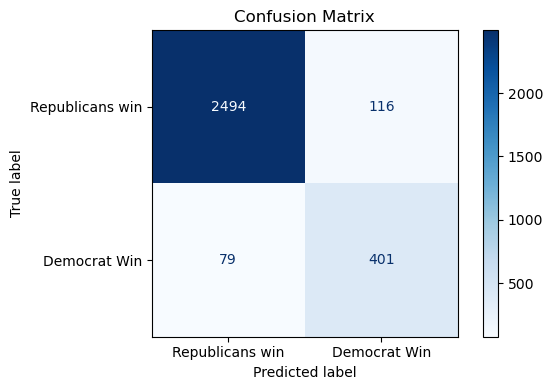


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.97      0.96      0.96      2610
   Democrat Win       0.78      0.84      0.80       480

       accuracy                           0.94      3090
      macro avg       0.87      0.90      0.88      3090
   weighted avg       0.94      0.94      0.94      3090



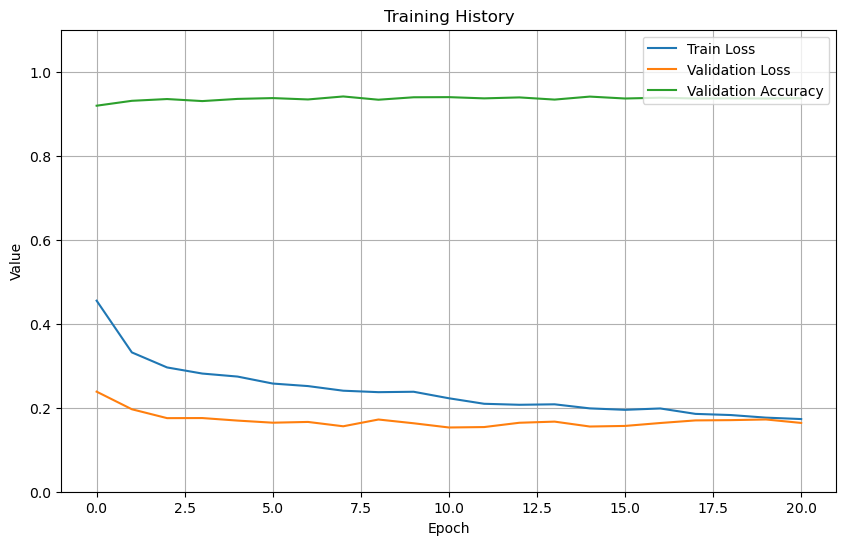

In [62]:
# --- 1. Predict on validation set ---
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()

BinaryClassifier(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.4745 | Val Loss: 0.3162 | Val Accuracy: 0.8958
Epoch 2/50 | Train Loss: 0.3614 | Val Loss: 0.2413 | Val Accuracy: 0.9223
Epoch 3/50 | Train Loss: 0.3268 | Val Loss: 0.2208 | Val Accuracy: 0.9262
Epoch 4/50 | Train Loss: 0.3097 | Val Loss: 0.2001 | Val Accuracy: 0.9285
Epoch 5/50 | Train Loss: 0.2913 | Val Loss: 0.1853 | Val Accuracy: 0.9311
Epoch 6/50 | Train Loss: 0.2838 | Val Loss: 0.1945 | Val Accuracy: 0.9278
Epoch 7/50 | Train Loss: 0.2790 | Val Loss: 0.1802 | Val Accuracy: 0.9320
Epoch 8/50 | Train Loss: 0.2695 | Val Loss: 0.1824 | Val Accuracy: 0.9330
Epoch 9/50 | Train Loss: 0.2657 | Val Loss: 0.1746 | Val Accuracy: 0.9291
Epoch 10/50 | Train Loss: 0.2627 | Val Loss: 0.1695 | Val Accuracy

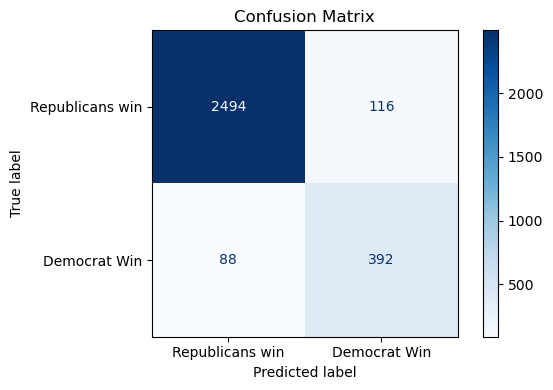


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.97      0.96      0.96      2610
   Democrat Win       0.77      0.82      0.79       480

       accuracy                           0.93      3090
      macro avg       0.87      0.89      0.88      3090
   weighted avg       0.94      0.93      0.93      3090



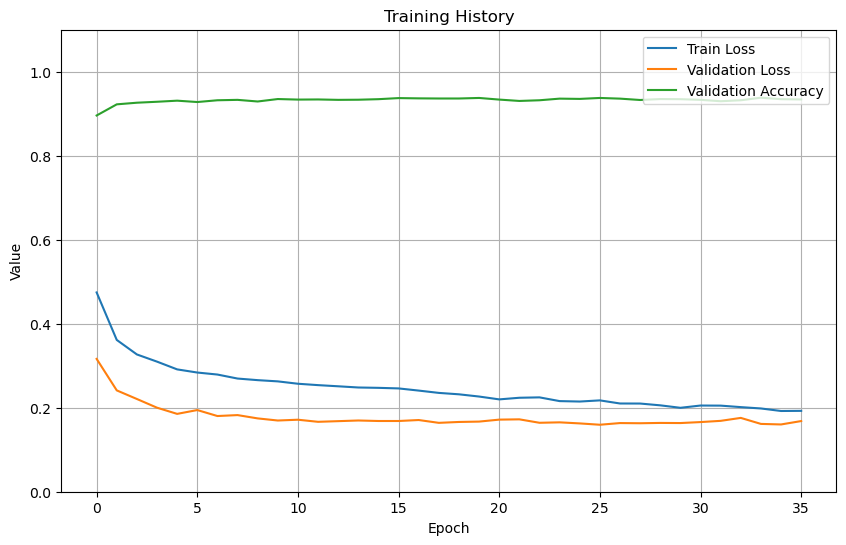

In [72]:

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Single output node with sigmoid for binary classification
        )
        
    def forward(self, x):
        return self.layer(x)

model = BinaryClassifier(X_tr_tensor.shape[1]).to(device)
print(model)

# --- 4. Loss and Optimizer ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=10)

epochs = 50
print("Starting model training...")

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_loss_history.append(val_loss)

        val_preds = (val_outputs >= 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        val_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    predicted = (val_outputs >= 0.5).float()
    accuracy = (predicted == y_val_tensor).float().mean().item()
    final_loss = criterion(val_outputs, y_val_tensor).item()

print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# --- 1. Predict on validation set ---
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()

BinaryClassifier(
  (layer): Sequential(
    (0): Linear(in_features=111, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Starting model training...
Epoch 1/50 | Train Loss: 0.6191 | Val Loss: 0.5951 | Val Accuracy: 0.7045
Epoch 2/50 | Train Loss: 0.5348 | Val Loss: 0.5513 | Val Accuracy: 0.7427
Epoch 3/50 | Train Loss: 0.4964 | Val Loss: 0.4845 | Val Accuracy: 0.7890
Epoch 4/50 | Train Loss: 0.4686 | Val Loss: 0.4532 | Val Accuracy: 0.8129
Epoch 5/50 | Train Loss: 0.4479 | Val Loss: 0.4250 | Val Accuracy: 0.8304
Epoch 6/50 | Train Loss: 0.4299 | Val Loss: 0.3996 | Val Accuracy: 0.8460
Epoch 7/50 | Train Loss: 0.4153 | Val Loss: 0.3799 | Val Accuracy: 0.8566
Epoch 8/50 | Train Loss: 0.4036 | Val Loss: 0.3605 | Val Accuracy: 0.8660
Epoch 9/50 | Train Loss: 0.3931 | Val Loss: 0.3459 | Val Accuracy: 0.8738
Epoch 10/50 | Train Loss: 0.3839 | Val Loss: 0.3273 | Val Accuracy: 0.8825
Epoch 11/50 | Train Loss: 0.3757 | Val Loss: 0.3164 | Val Accuracy: 0.8926
Epoch 12/50 | Train Loss: 0.368

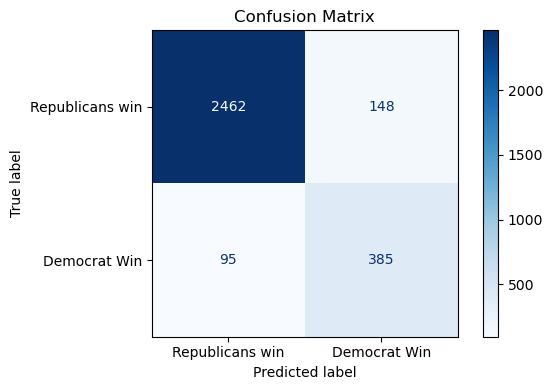


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.96      0.94      0.95      2610
   Democrat Win       0.72      0.80      0.76       480

       accuracy                           0.92      3090
      macro avg       0.84      0.87      0.86      3090
   weighted avg       0.93      0.92      0.92      3090



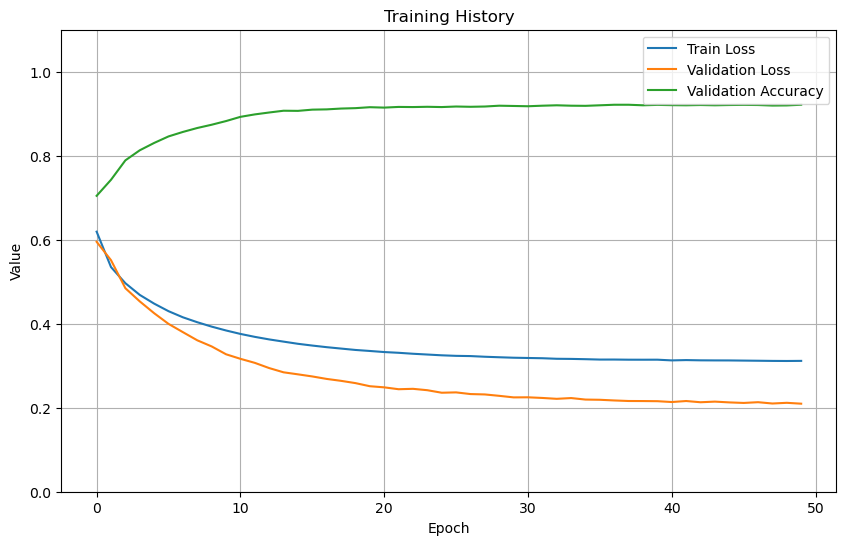

In [73]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()  # Logistic regression: linear layer + sigmoid
        )

    def forward(self, x):
        return self.layer(x)

model = BinaryClassifier(X_tr_tensor.shape[1]).to(device)
print(model)
# --- 4. Loss and Optimizer ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=10)

epochs = 50
print("Starting model training...")

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_loss_history.append(val_loss)

        val_preds = (val_outputs >= 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        val_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    predicted = (val_outputs >= 0.5).float()
    accuracy = (predicted == y_val_tensor).float().mean().item()
    final_loss = criterion(val_outputs, y_val_tensor).item()

print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# --- 1. Predict on validation set ---
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()

LinearRegressionModel(
  (linear): Linear(in_features=111, out_features=1, bias=True)
)
Starting model training...
Epoch 1/50 | Train Loss: 0.3107 | Val Loss: 0.1345 | Val Accuracy: 0.8783
Epoch 2/50 | Train Loss: 0.1614 | Val Loss: 0.0947 | Val Accuracy: 0.9013
Epoch 3/50 | Train Loss: 0.1330 | Val Loss: 0.0828 | Val Accuracy: 0.9146
Epoch 4/50 | Train Loss: 0.1219 | Val Loss: 0.0796 | Val Accuracy: 0.9282
Epoch 5/50 | Train Loss: 0.1171 | Val Loss: 0.0791 | Val Accuracy: 0.9243
Epoch 6/50 | Train Loss: 0.1151 | Val Loss: 0.0801 | Val Accuracy: 0.9272
Epoch 7/50 | Train Loss: 0.1136 | Val Loss: 0.0771 | Val Accuracy: 0.9285
Epoch 8/50 | Train Loss: 0.1138 | Val Loss: 0.0776 | Val Accuracy: 0.9282
Epoch 9/50 | Train Loss: 0.1129 | Val Loss: 0.0787 | Val Accuracy: 0.9259
Epoch 10/50 | Train Loss: 0.1131 | Val Loss: 0.0783 | Val Accuracy: 0.9262
Epoch 11/50 | Train Loss: 0.1122 | Val Loss: 0.0771 | Val Accuracy: 0.9275
Epoch 12/50 | Train Loss: 0.1124 | Val Loss: 0.0786 | Val Accuracy: 0

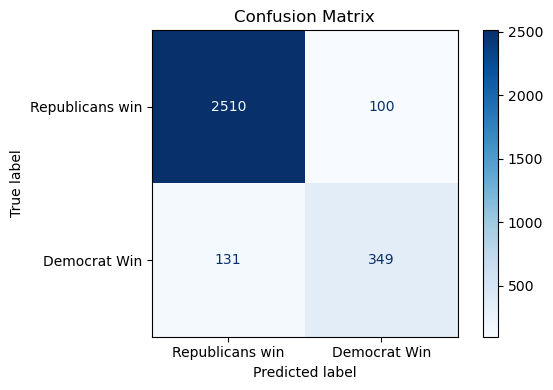


Classification Report:
                 precision    recall  f1-score   support

Republicans win       0.95      0.96      0.96      2610
   Democrat Win       0.78      0.73      0.75       480

       accuracy                           0.93      3090
      macro avg       0.86      0.84      0.85      3090
   weighted avg       0.92      0.93      0.92      3090



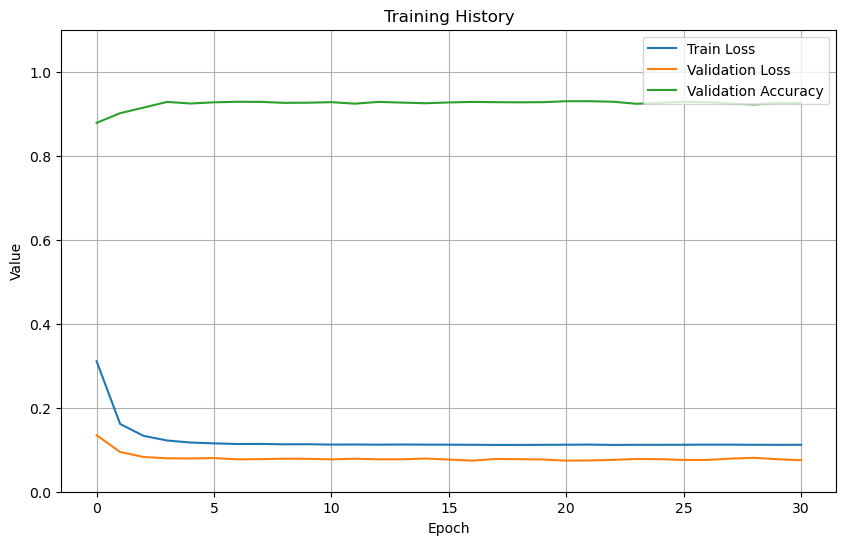

In [74]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Just a single linear layer

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel(X_tr_tensor.shape[1]).to(device)
print(model)


# --- 4. Loss and Optimizer ---
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters())

# --- 5. Early Stopping Setup ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=10)

epochs = 50
print("Starting model training...")

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_loss_history.append(val_loss)

        val_preds = (val_outputs >= 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean().item()
        val_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


print("Model training finished.")

# --- 7. Evaluation ---
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor).squeeze()
    mae = torch.mean(torch.abs(val_preds - y_val_tensor)).item()
    print(f"Validation MAE: {mae:.4f}")


print(f"\nTest Loss: {final_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# --- 1. Predict on validation set ---
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_val_tensor).squeeze().cpu().numpy()  # Convert to NumPy array
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- 2. Prepare ground truth labels ---
y_test_flat = y_val_tensor.cpu().numpy().flatten()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test_flat, y_pred)
class_names = ['Republicans win', 'Democrat Win']  # Adjust this as needed

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, target_names=class_names))


history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

history_df.plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.ylim(0, 1.1 * max(history_df.max().max(), 1))
plt.legend(loc='upper right')
plt.show()